In [1]:
!pip install albumentations
!pip install torchmetrics
!pip install paddleocr>=2.0.1 paddlepaddle
!pip install opencv-python-headless==4.5.3.56
!pip install segmentation_models_pytorch

     |██████                          | 166.7 MB 1.3 MB/s eta 0:09:02^C

ERROR: Operation cancelled by user


In [1]:
%%time
## STANDARD LIBRARY AND PIPELINE MODULES IMPORT
import warnings
warnings.filterwarnings("ignore")
from pipeline import segmentation
from pipeline import correct_perspective
from pipeline.rules import ru, find_nearby
from pipeline import OCR
from pipeline import classifier
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

[2023/02/06 17:39:46] ppocr DEBUG: Namespace(alpha=1.0, benchmark=False, beta=1.0, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/home/drobot/.paddleocr/whl/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/home/drobot/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.4, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_p

In [2]:
%%time
## EVALUATION ON EACH IMAGE
img_classes = [ 'BPL-EliteView-EV10-B_Meditec-England-A', 'BPL-EliteView-EV100-C' , 'BPL-Ultima-PrimeD-A' , 'Nihon-Kohden-lifescope-A']
TEST_IMG_DIR = f"val/{img_classes[0]}"

imlis = os.listdir(TEST_IMG_DIR)
imloc = f"{TEST_IMG_DIR}/{imlis[5]}"
imloc = "test_data/tridevdeoghar_icu_mon--4_2023_1_5_0_20_2.jpeg"
image = cv2.cvtColor(cv2.imread(imloc), cv2.COLOR_BGR2RGB)
ocr_io = cv2.resize(image, (320, 180))
class_io = cv2.resize(image, (640, 360))


mask = segmentation.maskPred(image)
# # # print(mask)
(ocr_io, class_io, orig_io) =  correct_perspective.correctPerspective(image, mask)
label = classifier.classification(class_io) 

#label = 2
if label==1:
    candidates =  OCR.get_text(class_io, det=True)
    ocr_io = class_io
elif label == 3:
    # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    # ocr_io = cv2.filter2D(ocr_io, -1, kernel)
    
    candidates =  OCR.get_text(ocr_io[:, :115], det=True)
else:
    print("here")
    candidates =  OCR.get_text(ocr_io, det=True)
can = candidates[0]
# plt.imshow(ocr_io[:, :115])
# plt.show()

result = {}
hr_boxes = []

boxes = []
yellow_boxes = []
slash_box = []
for line in can:
    bbox = line[0]
    txt = line[1][0]
    confidence = line[1][1]
    
    x1, y1, x2, y2 = int(bbox[0][0]),int(bbox[0][1]) , int(bbox[2][0]),int(bbox[2][1])
    cropped = ocr_io[y1: y2, x1:x2]
    # print(x1, y1,x2,y2)
    # print(txt)
    # plt.imshow(cropped)
    # plt.show()
    pred = ru.class_pred(txt, cropped, label)
    if len(re.findall("^/\d+", txt.strip()))>0:
        slash_box = [(x1+x2)/2, (y1+y2)/2, x2-x1,y2-y1, txt]
    else:
        boxes.append([(x1+x2)/2, (y1+y2)/2, x2-x1,y2-y1, txt ])
    if len(pred)>0:
        clas = pred[0]
        if(clas=="BP"):
            result[pred[1][0][0]] = pred[1][0][1]
            result[pred[1][1][0]] = pred[1][1][1]
        elif(clas == 'HR'):
            hr_boxes.append([cropped.shape[0]*cropped.shape[1], [x1,y1,x2,y2], pred])
        elif(clas == 'cyan'):
            if label == 1:
                result['RR'] = pred[1]
            elif label==0 or label == 2: 
                result['SPO2'] = pred[1]
        elif(clas=='yellow'):
            if label == 1:
                yellow_boxes.append([(y1+y2)/2, cropped.shape[0]*cropped.shape[1], [x1,y1,x2,y2], txt])
            elif label == 0 or label == 2:
                result['RR'] = txt
            elif label == 3:
                result['SPO2'] = txt
                
#         print(txt ,"-", len(pred))
yellow_boxes = sorted(yellow_boxes, key=lambda x: x[0], reverse=True)
hr_boxes = sorted(hr_boxes, key=lambda x: x[0], reverse=True)

if label == 1 and len(yellow_boxes) > 0:
    result['SPO2'] = yellow_boxes[0][3]

if len(hr_boxes)>0:
    x1,y1,x2,y2 = hr_boxes[0][1]
    hr = (hr_boxes[0][2][1][0])
    a = re.findall('^\d+', hr)
    hr = int(a[0])
    if int(a[0][:3]) > 220:
        hr = int(a[0][:2])
    elif int(a[0]) > 300:
        hr = int(a[0][:3])
    result['HR'] = hr
#         plt.imshow(ocr_io[y1: y2, x1:x2])
#         plt.show()

if len(slash_box) > 0:
    index = find_nearby(slash_box, boxes)
    x, y, w, h, pred = boxes[index]
    
    result['SBP'] = pred.strip()
    result['DBP'] = slash_box[-1][1:]

boxes = sorted(boxes, key= lambda x: x[1], reverse=True)
if label == 3:
    for (x,y,w,h,pred) in boxes:
        if w*h > 200:
            if pred[1] == 'T':
                pred = pred[0] + '7'
            result['RR'] = pred
            break



print(result)

[2023/02/06 17:39:48] ppocr WARNING: Since the angle classifier is not initialized, the angle classifier will not be uesd during the forward process
[2023/02/06 17:39:48] ppocr DEBUG: dt_boxes num : 6, elapse : 0.10231685638427734
[2023/02/06 17:39:49] ppocr DEBUG: rec_res num  : 6, elapse : 0.5131816864013672
{'HR': 70, 'RR': '21'}
CPU times: user 6.55 s, sys: 413 ms, total: 6.96 s
Wall time: 1.4 s


True

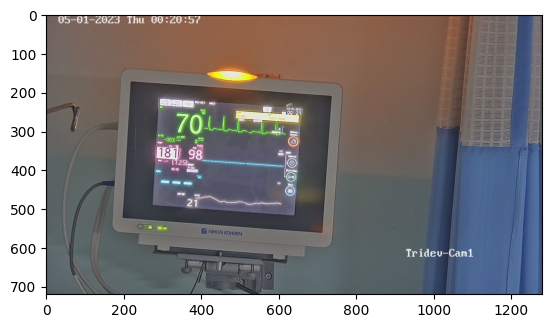

In [3]:
plt.imshow(image)
cv2.imwrite('results/pipeline_imgs/ip.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [28]:
print(label)

3


255

True

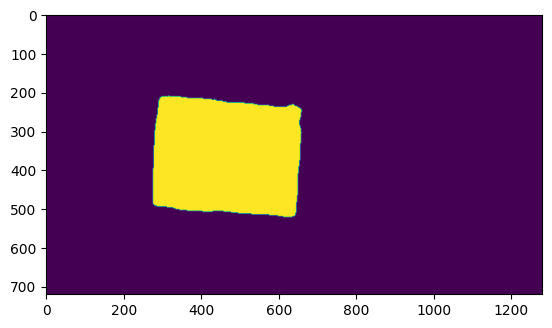

In [42]:
plt.imshow(mask)
cv2.imwrite('results/pipeline_imgs/mask.jpg', cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))

True

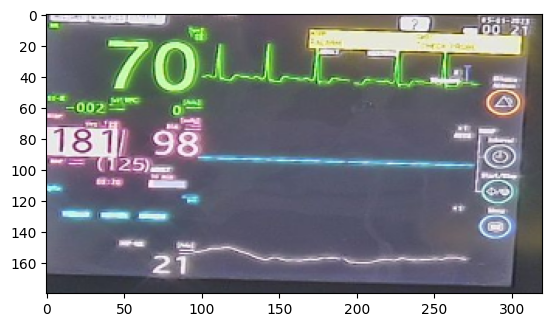

In [43]:

plt.imshow(ocr_io)
cv2.imwrite('results/pipeline_imgs/ocr_io.jpg', cv2.cvtColor(ocr_io, cv2.COLOR_RGB2BGR))

True

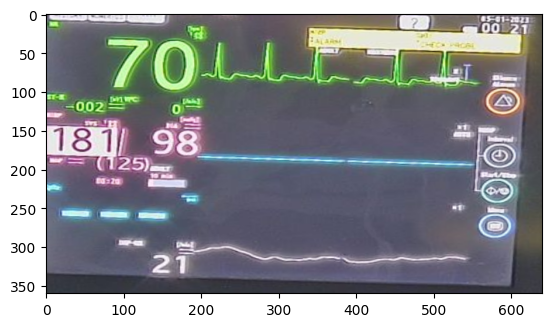

In [44]:

plt.imshow(class_io)
cv2.imwrite('results/pipeline_imgs/class_io.jpg', cv2.cvtColor(class_io, cv2.COLOR_RGB2BGR))

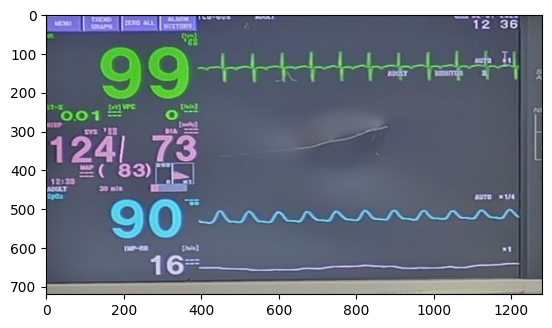

In [7]:
plt.imshow(orig_io)

In [25]:

for b in can:
    a, b = (int(b[0][0][0]), int(b[0][0][1])), (int(b[0][2][0]), int(b[0][2][1]))
    
    cv2.rectangle(ocr_io, tuple(a), tuple(b), (255, 0, 0), 2)

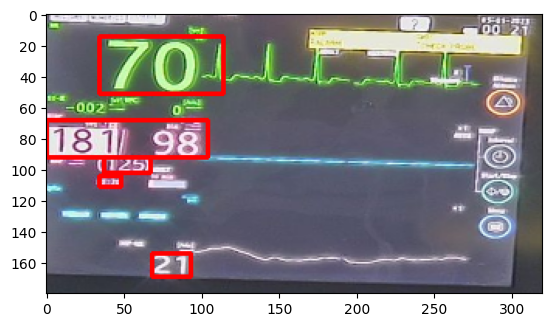

In [26]:
plt.imshow(ocr_io)
cv2.imwrite('results/pipeline_imgs/ocr_op.jpg', cv2.cvtColor(class_io, cv2.COLOR_RGB2BGR))

In [12]:
[0]

array([[ 34.,  14.],
       [112.,   8.],
       [114.,  51.],
       [ 38.,  57.]])